<a href="https://colab.research.google.com/github/AguaClara/CEE4520/blob/master/Unit_Process_Designs/Coagulant_Dose_FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coagulant Dose Estimator

The goal is to estimate a reasonable coagulant dose given the raw water turbidity and apparent color. 

Apparent color is corrected for false color caused by turbidity using a relationship that was obtained from analysis in the Gracias water treatment plant laboratory. Raw water turbidity multiplied by 7.5 yields the false color.

True color is then converted to Total Organic Carbon using the table below from:

[Natural Organic Matter in Drinking Water: Recommendations to Water Utilities
By Billy H. Kornegay, Keith J. Kornegay, Evelyn Torres, AWWA Research Foundation](https://books.google.com/books?id=rVb-EL1OBToC&pg=PA75&lpg=PA75&dq=correlation+between+color+and+TOC&source=bl&ots=uxnFvEMRdZ&sig=ACfU3U08cWlzkKiRQvgEy5dk15IQv12TEA&hl=en&sa=X&ved=2ahUKEwjappGSsZjqAhXCSt8KHciyBukQ6AEwA3oECAgQAQ#v=onepage&q&f=false)

![alt text](https://github.com/AguaClara/CEE4520/raw/master/Unit_Process_Designs/images/Color-TOC-alum_table.PNG)

Color is converted to TOC using a factor of 7.73. The only Natural Organic Matter that we have characterized for coagulant demand is humic acid. We quantified the humic acid based on total dry mass. Organic matter is about 50 % carbon and thus to get the total dry mass we multiply the TOC by 2.

In [2]:
!pip install aguaclara

     |████████████████████████████████| 92kB 2.7MB/s 
     |████████████████████████████████| 204kB 8.3MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.4-cp36-none-any.whl size=99459 sha256=1ae77d523d8ba8dd17255ccce81ad3bdcf87742fbc0cf1f0fbef63ed52b1c134
  Stored in directory: /root/.cache/pip/wheels/13/8f/96/21ca9dd731bb0b86c16855c39ce375604b9a745f3ed388ac51
Successfully built aguaclara


In [3]:
##import
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 



# Natural organic matter diameter estimation based on molecular weight

[Fulvic acid](https://pubchem.ncbi.nlm.nih.gov/compound/Fulvic-acid) molecular weight is 308.24.
The density of organic matter [The density of humic acids and humic like substances (HULIS) from fresh and aged wood burning and pollution aerosol particles](https://www.atmos-chem-phys.net/6/5213/2006/acp-6-5213-2006.pdf) is about 1.5 m/mL.

The fulvic binding to PACl is given by this stoichiometry from [Chemical aspects of coagulation using aluminum salts—II. coagulation of fulvic acid using alum and polyaluminum chloride](https://doi.org/10.1016/0043-1354(90)90087-M)

$$Al(OH)_{2.8}FA_{0.63}$$

[Size and Charge Evaluation of Standard Humic and Fulvic Acids as Crucial Factors to Determine Their Environmental Behavior and Impact](10.3389/fchem.2018.00235) shows that humic acid has a peak at about 70 nm for a size distribution by number and that fulvic acid has a peak around 250 nm. This suggests that fulvic acid would take less coagulant than humic acid. It also suggest that the individual molecules of fulvic acid aren't being adsorbed by PACl nanoparticles. Thus modeling humic acid based on its molecular weight and coverage of the coagulant nanoparticles is incorrect.

Therefore given a concentration of fulvic acid, the concentration of Al would be the 

$$ vol = \frac{\pi}{6}d^3$$

$$d = \left(\frac{6 vol}{\pi}\right)^{\frac{1}{3}}$$

In [4]:
fulvic_MW = 308.24 * u.g / u.mol
fulvic_mass_per_molecule = (fulvic_MW * u.mol /u.avogadro_number).to(u.ng)
fulvic_density = 1.5 * u.g/u.mL
fulvic_volume = fulvic_mass_per_molecule / fulvic_density
fulvic_diameter = ((6*fulvic_volume/np.pi)**(1/3)).to(u.nm)
print(fulvic_diameter)

0.867 nanometer


In [5]:
## constants & variables for floc model
DiamTube = 4 * u.inch
Temp = 10 * u.degC
Time = 4 * u.min
EnergyDis = 40 * u.cm * u.gravity / Time
NatOrgMat = ac.HumicAcid
material = ac.Clay
coag = ac.PACl
FittingParam = 0.13
RatioHeightDiameter = 0.2

The concentration of organic matter is estimated to be 12.82 milligram / liter
The coagulant dose as aluminum for humic organics is 4.499 milligram / liter or approximately 13.5 milligram / liter as PACl.
The coagulant dose as aluminum for fulvic acid given 1 nm particles is 20 milligram / liter or approximately 60 milligram / liter as PACl.
The coagulant dose as aluminum for fulvic acid is 1.303 milligram / liter or approximately 3.908 milligram / liter as PACl.
The coagulant dose as aluminum for fulvic acid based on stoichiometry is 1.783 milligram / liter or approximately 5.348 milligram / liter as PACl.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


<function matplotlib.pyplot.show>

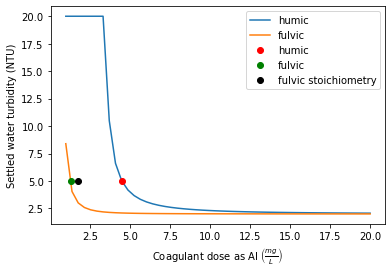

In [9]:
Raw_Turbidity = 20 * u.NTU
Color = 200
Target_Turbidity = 5 * u.NTU



True_Color = Color - Raw_Turbidity*7.5/(u.NTU)
TOC = True_Color / 7.8 * u.mg/u.L
ConcNatOrgMat = TOC*2

print('The concentration of organic matter is estimated to be', ConcNatOrgMat)

molarity_fulvic = (ConcNatOrgMat/fulvic_MW).to(u.mol/u.L)
Stoich_Al_conc = (molarity_fulvic /0.63 * 27 * u.g/u.mol).to(u.mg/u.L)
ConcAl = np.linspace(1,20) * u.mg/u.L
#define a possible organic molecule that makes the water yellow. The molecular weight is bogus and isn't used.
humic = ac.Material('humic',36*u.nm,900 * u.kg/u.m**3,fulvic_MW)
fulvic_tiny = ac.Material('fulvic',fulvic_diameter,fulvic_density,fulvic_MW)
fulvic = ac.Material('fulvic',90 * u.nm,fulvic_density,fulvic_MW)

Eff_Turbidity_humic = (ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, Raw_Turbidity, ConcAl, ConcNatOrgMat, humic, coag, material, FittingParam, RatioHeightDiameter)) * Raw_Turbidity)
Eff_Turbidity_fulvic_tiny = (ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, Raw_Turbidity, ConcAl, ConcNatOrgMat, fulvic_tiny, coag, material, FittingParam, RatioHeightDiameter)) * Raw_Turbidity)
Eff_Turbidity_fulvic = (ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, Raw_Turbidity, ConcAl, ConcNatOrgMat, fulvic, coag, material, FittingParam, RatioHeightDiameter)) * Raw_Turbidity)

# reverse the arrays so that the y array is ascending
Al_Dose_humic = np.interp(Target_Turbidity, Eff_Turbidity_humic[::-1], ConcAl[::-1])
print('The coagulant dose as aluminum for humic organics is',Al_Dose_humic,'or approximately',3*Al_Dose_humic,'as PACl.')
Al_Dose_fulvic_tiny = np.interp(Target_Turbidity, Eff_Turbidity_fulvic_tiny[::-1], ConcAl[::-1])
print('The coagulant dose as aluminum for fulvic acid given 1 nm particles is',Al_Dose_fulvic_tiny,'or approximately',3*Al_Dose_fulvic_tiny,'as PACl.')
Al_Dose_fulvic = np.interp(Target_Turbidity, Eff_Turbidity_fulvic[::-1], ConcAl[::-1])
print('The coagulant dose as aluminum for fulvic acid is',Al_Dose_fulvic,'or approximately',3*Al_Dose_fulvic,'as PACl.')
print('The coagulant dose as aluminum for fulvic acid based on stoichiometry is',Stoich_Al_conc,'or approximately',3*Stoich_Al_conc,'as PACl.')
plt.plot(ConcAl,Eff_Turbidity_humic);
plt.plot(ConcAl,Eff_Turbidity_fulvic);
plt.xlabel(r'Coagulant dose as Al $\left(\frac{mg}{L}\right)$');
plt.ylabel('Settled water turbidity (NTU)');
plt.plot(Al_Dose_humic,Target_Turbidity,'ro');
plt.plot(Al_Dose_fulvic,Target_Turbidity,'go');
plt.plot(Stoich_Al_conc,Target_Turbidity,'ko');
plt.legend(['humic','fulvic','humic','fulvic','fulvic stoichiometry'])
plt.show

For raw water dominated by turbidity use the following code to estimate the coagulant dose.

In [17]:
Raw_Turbidity = 18 * u.NTU
Target_Turbidity = 2 * u.NTU
ConcNatOrgMat=0 * u.mg/u.L
ConcAl = np.linspace(1,20) * u.mg/u.L
# 
# ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, Raw_Turbidity, ConcAl, ConcNatOrgMat, humic, coag, material, FittingParam, RatioHeightDiameter)
Eff_Turbidity_clay = (ac.invp(ac.pc_viscous(EnergyDis, Temp, Time, DiamTube, Raw_Turbidity, ConcAl, ConcNatOrgMat, humic, ac.PACl, ac.Clay, FittingParam, RatioHeightDiameter)) * Raw_Turbidity)
# reverse the arrays so that the y array is ascending
Al_Dose_clay = np.interp(Target_Turbidity, Eff_Turbidity_clay[::-1], ConcAl[::-1])
print('The coagulant dose as aluminum for clay is',Al_Dose_clay,'or approximately',3*Al_Dose_clay,'as PACl.')

The coagulant dose as aluminum for clay is 1.876 milligram / liter or approximately 5.628 milligram / liter as PACl.


In [14]:
print(ac.PACl.Density)

1138 kilogram / meter ** 3
